In [72]:
!git clone https://github.com/NathanUA/U-2-Net.git

Cloning into 'U-2-Net'...
remote: Enumerating objects: 1074, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 1074 (delta 30), reused 48 (delta 23), pack-reused 1017
Receiving objects: 100% (1074/1074), 66.96 MiB | 30.72 MiB/s, done.
Resolving deltas: 100% (517/517), done.


In [80]:
import sys
sys.path.append('/content/U-2-Net')

In [81]:
import os
import time
from collections import namedtuple
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
from IPython.display import HTML, FileLink, display
from model.u2net import U2NET, U2NETP

In [100]:
IMAGE_DIR = "data"
model_config = namedtuple("ModelConfig", ["name", "url", "model", "model_args"])

u2net_lite = model_config(
    name="u2net_lite",
    url="https://drive.google.com/uc?id=1rbSTGKAE-MTxBYHd-51l2hMOQPT_7EPy",
    model=U2NETP,
    model_args=(),
)
u2net = model_config(
    name="u2net",
    url="https://drive.google.com/uc?id=1ao1ovG1Qtx4b7EoskHXmi2E9rp5CHLcZ",
    model=U2NET,
    model_args=(3, 1),
)
u2net_human_seg = model_config(
    name="u2net_human_seg",
    url="https://drive.google.com/uc?id=1-Yg0cxgrNhHP-016FPdp902BR-kSsA4P",
    model=U2NET,
    model_args=(3, 1),
)

# Set u2net_model to one of the three configurations listed above.
u2net_model = u2net

In [102]:
# The filenames of the downloaded and converted models.
MODEL_DIR = "saved_models"
model_path = Path(MODEL_DIR) / u2net_model.name / Path(u2net_model.name).with_suffix(".pth")

In [106]:
if not model_path.exists():
    import gdown

    os.makedirs(name=model_path.parent, exist_ok=True)
    print("Start downloading model weights file... ")
    with open(model_path, "wb") as model_file:
        gdown.download(url=u2net_model.url, output=model_file)
        print(f"Model weights have been downloaded to {model_path}")

Start downloading model weights file... 


Downloading...
From: https://drive.google.com/uc?id=1ao1ovG1Qtx4b7EoskHXmi2E9rp5CHLcZ
To: <_io.BufferedWriter name='saved_models/u2net/u2net.pth'>
100%|██████████| 176M/176M [00:00<00:00, 207MB/s]

Model weights have been downloaded to saved_models/u2net/u2net.pth


In [89]:
# Load the model.
net = u2net_model.model(*u2net_model.model_args)

if torch.cuda.is_available():
    net.load_state_dict(torch.load(model_path))
    net.cuda()
else:
    net.load_state_dict(torch.load(model_path, map_location='cpu'))
net.eval()

# Load the weights.
print(f"Loading model weights from: '{model_path}'")
net.load_state_dict(state_dict=torch.load(model_path, map_location="cpu"))

# Save the model if it does not exist yet.
if not model_path.exists():
    print("\nSaving the model")
    torch.save(obj=net.state_dict(), f=str(model_path))
    print(f"Model saved at {model_path}")

Loading model weights from: 'model/u2net_lite/u2net_lite.pth'


In [121]:
import os
from skimage import io, transform
import torch
import torchvision
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms#, utils
# import torch.optim as optim

import numpy as np
from PIL import Image
import glob

from data_loader import RescaleT
from data_loader import ToTensor
from data_loader import ToTensorLab
from data_loader import SalObjDataset

from model import U2NET # full size version 173.6 MB
from model import U2NETP # small version u2net 4.7 MB

# normalize the predicted SOD probability map
def normPRED(d):
    ma = torch.max(d)
    mi = torch.min(d)

    dn = (d-mi)/(ma-mi)

    return dn

def save_output(image_name,pred,d_dir):

    print("Saving images yo")

    predict = pred
    predict = predict.squeeze()
    predict_np = predict.cpu().data.numpy()

    im = Image.fromarray(predict_np*255).convert('RGB')
    img_name = image_name.split(os.sep)[-1]
    image = io.imread(image_name)
    imo = im.resize((image.shape[1],image.shape[0]),resample=Image.BILINEAR)

    pb_np = np.array(imo)

    aaa = img_name.split(".")
    bbb = aaa[0:-1]
    imidx = bbb[0]
    for i in range(1,len(bbb)):
        imidx = imidx + "." + bbb[i]

    imo.save(d_dir+imidx+'.png')

def main():

    # --------- 1. get image path and name ---------
    model_name='u2net'#u2netp



    image_dir = os.path.join(os.getcwd(), 'test_data', 'test_images')
    prediction_dir = os.path.join(os.getcwd(), 'test_data', model_name + '_results' + os.sep)
    model_dir = os.path.join(os.getcwd(), 'saved_models', model_name, model_name + '.pth')

    img_name_list = glob.glob(image_dir + os.sep + '*')
    print(img_name_list)

    # --------- 2. dataloader ---------
    #1. dataloader
    test_salobj_dataset = SalObjDataset(img_name_list = img_name_list,
                                        lbl_name_list = [],
                                        transform=transforms.Compose([RescaleT(320),
                                                                      ToTensorLab(flag=0)])
                                        )
    test_salobj_dataloader = DataLoader(test_salobj_dataset,
                                        batch_size=1,
                                        shuffle=False,
                                        num_workers=1)

    # --------- 3. model define ---------
    if(model_name=='u2net'):
        print("...load U2NET---173.6 MB")
        net = U2NET(3,1)
    elif(model_name=='u2netp'):
        print("...load U2NEP---4.7 MB")
        net = U2NETP(3,1)

    if torch.cuda.is_available():
        net.load_state_dict(torch.load(model_dir))
        net.cuda()
    else:
        net.load_state_dict(torch.load(model_dir, map_location='cpu'))
    net.eval()

    # --------- 4. inference for each image ---------
    for i_test, data_test in enumerate(test_salobj_dataloader):

        print("inferencing:",img_name_list[i_test].split(os.sep)[-1])

        inputs_test = data_test['image']
        inputs_test = inputs_test.type(torch.FloatTensor)

        if torch.cuda.is_available():
            inputs_test = Variable(inputs_test.cuda())
        else:
            inputs_test = Variable(inputs_test)

        d1,d2,d3,d4,d5,d6,d7= net(inputs_test)

        # normalization
        pred = d1[:,0,:,:]
        pred = normPRED(pred)

        # save results to test_results folder
        if not os.path.exists(prediction_dir):
            os.makedirs(prediction_dir, exist_ok=True)
        save_output(img_name_list[i_test],pred,prediction_dir)

        del d1,d2,d3,d4,d5,d6,d7

In [119]:
%cd ./U-2-Net

/content/U-2-Net


In [123]:
main()

['/content/U-2-Net/test_data/test_images/rifle1.jpg', '/content/U-2-Net/test_data/test_images/bike.jpg', '/content/U-2-Net/test_data/test_images/lamp2_meitu_1.jpg', '/content/U-2-Net/test_data/test_images/rifle2.jpeg', '/content/U-2-Net/test_data/test_images/0003.jpg', '/content/U-2-Net/test_data/test_images/im_27.png', '/content/U-2-Net/test_data/test_images/im_01.png', '/content/U-2-Net/test_data/test_images/sailboat3.jpg', '/content/U-2-Net/test_data/test_images/0002-01.jpg', '/content/U-2-Net/test_data/test_images/im_14.png', '/content/U-2-Net/test_data/test_images/girl.png', '/content/U-2-Net/test_data/test_images/long.jpg', '/content/U-2-Net/test_data/test_images/whisk.png', '/content/U-2-Net/test_data/test_images/hockey.png', '/content/U-2-Net/test_data/test_images/vangogh.jpeg', '/content/U-2-Net/test_data/test_images/boat.jpg', '/content/U-2-Net/test_data/test_images/im_21.png', '/content/U-2-Net/test_data/test_images/cushion.jpg', '/content/U-2-Net/test_data/test_images/horse

In [109]:
ls

mask.png  model/  pillow.png  sample_data/  saved_models/  U-2-Net/


In [96]:
!ls ./saved_models

face_detection_cv2


# Basic Usage

1. install client and connect to the API

In [1]:
#%pip install ..
%pip install stability-sdk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import getpass, os

# NB: host url is not prepended with \"https\" nor does it have a trailing slash.
os.environ['STABILITY_HOST'] = 'grpc.stability.ai:443'

# To get your API key, visit https://beta.dreamstudio.ai/membership
os.environ['STABILITY_KEY'] = getpass.getpass('Enter your API Key')

Enter your API Key··········


In [135]:
import io
import os
import warnings

from IPython.display import display
from PIL import Image
from stability_sdk import client
import stability_sdk.interfaces.gooseai.generation.generation_pb2 as generation


stability_api = client.StabilityInference(
    key=os.environ['STABILITY_KEY'], 
    verbose=True,
)

INFO:stability_sdk.client:Opening channel to grpc.stability.ai:443
INFO:stability_sdk.client:Channel opened to grpc.stability.ai:443


2. Submit a request to generate a single image from a text prompt

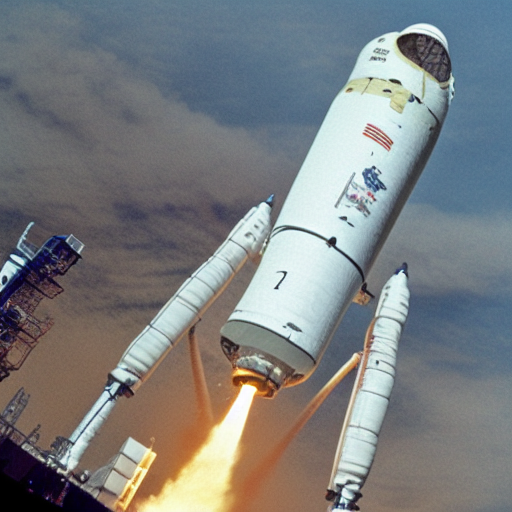

In [ ]:
# the object returned is a python generator
answers = stability_api.generate(
    prompt="houston, we are a 'go' for launch!",
    seed=34567, # if provided, specifying a random seed makes results deterministic
    steps=30, # defaults to 50 if not specified
)

# iterating over the generator produces the api response
for resp in answers:
    for artifact in resp.artifacts:
        if artifact.finish_reason == generation.FILTER:
            warnings.warn(
                "Your request activated the API's safety filters and could not be processed."
                "Please modify the prompt and try again.")
        if artifact.type == generation.ARTIFACT_IMAGE:
            img = Image.open(io.BytesIO(artifact.binary))
            display(img)

# Intermediate usage

3. (new!) An "init" image can be provided for text-driven image modification. To demonstrate, we can convert the image we just generated to a colored pencil sketch

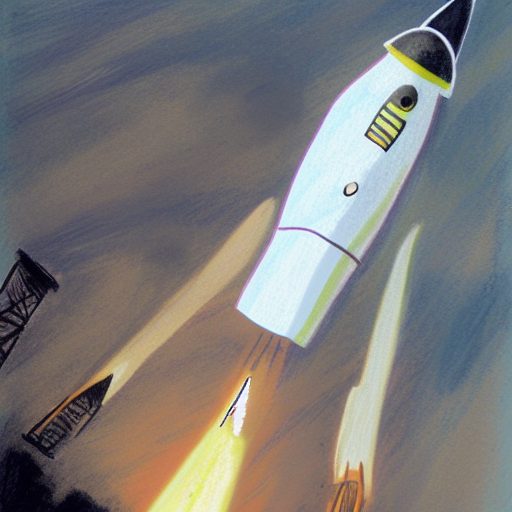

In [ ]:
answers = stability_api.generate(
    prompt="childrens crayon drawing of a rocket launch",
    init_image=img,
    seed=54321, # if we're passing in an image generated by SD, you may get better results by providing a different seed value than was used to generate the image
    start_schedule=0.6, # this controls the "strength" of the prompt relative to the init image
)

# iterating over the generator produces the api response
for resp in answers:
    for artifact in resp.artifacts:
        if artifact.finish_reason == generation.FILTER:
            warnings.warn(
                "Your request activated the API's safety filters and could not be processed."
                "Please modify the prompt and try again.")
        if artifact.type == generation.ARTIFACT_IMAGE:
            img2 = Image.open(io.BytesIO(artifact.binary))
            display(img2)

In [67]:
import cv2
import matplotlib.pyplot as plt
import requests
from io import BytesIO
from google.colab.patches import cv2_imshow

In [131]:
response = requests.get('https://github.com/jadechip/maurice-compressed/blob/main/cushion/E6166F02-431F-4DA8-A9B5-2D8F839B3AB1.jpg?raw=true')
img2 = Image.open(BytesIO(response.content))
img2.save('pillow.png')

In [69]:
im = cv2.imread("pillow.png", cv2.IMREAD_UNCHANGED)
ret, mask = cv2.threshold(im[:, :, 2], 0, 255, cv2.THRESH_BINARY)
cv2.imwrite('mask.png', mask)

True

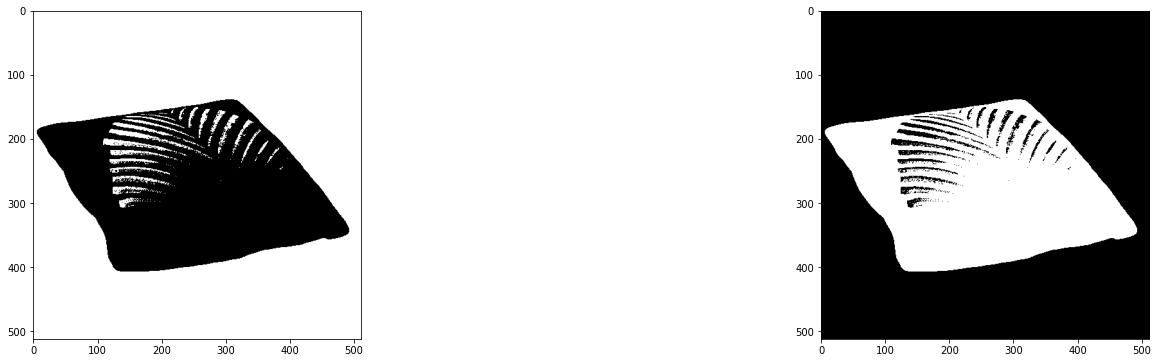

In [71]:
# Load the image
img = cv2.imread('pillow.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Creating the mask for the roi and small image
img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
_, mask = cv2.threshold(img_gray, 254/2+100, 255, cv2.THRESH_BINARY)
mask_inv = cv2.bitwise_not(mask)
plt.figure(figsize = (20, 20))
plt.subplot(1, 3, 1); plt.imshow(mask, cmap = 'gray')
plt.subplot(1, 3, 3); plt.imshow(mask_inv, cmap = 'gray')

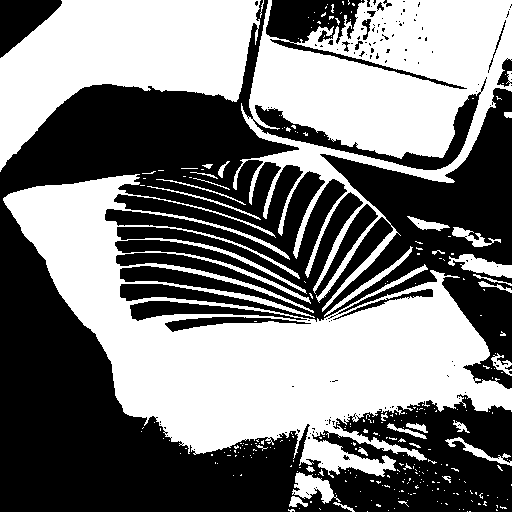

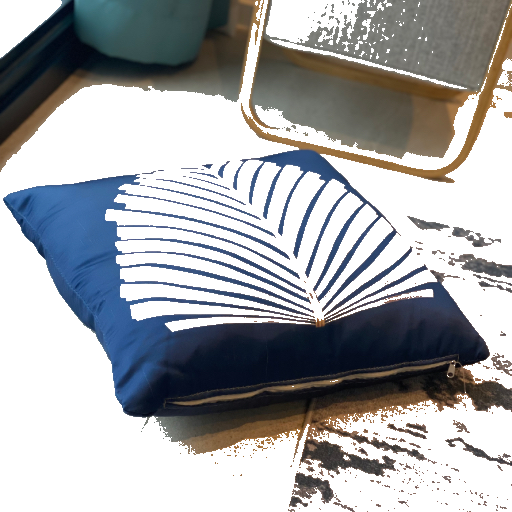

-1

In [57]:
image = cv2.imread('pillow.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

# Remove background using bitwise-and operation
result = cv2.bitwise_and(image, image, mask=thresh)
result[thresh==0] = [255,255,255] # Turn background white

cv2_imshow(thresh)
cv2_imshow(result)
cv2.waitKey()

In [60]:
# load image
img = cv2.imread("pillow.jpg", cv2.IMREAD_GRAYSCALE);

# otsu thresholding
_, mask = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU);

# show
# cv2_imshow(mask);
# cv2.waitKey(0);

# close everything inside
contour, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE);

# get the biggest contour # returns _, contours, _ if using OpenCV 3
biggest_area = -1;
biggest = None;
for con in contour:
    area = cv2.contourArea(con);
    if biggest_area < area:
        biggest_area = area;
        biggest = con;

# fill in the contour
cv2.drawContours(mask, [biggest], -1, 255, -1);

# show
cv2_imshow(mask);
cv2.waitKey(0);

error: ignored

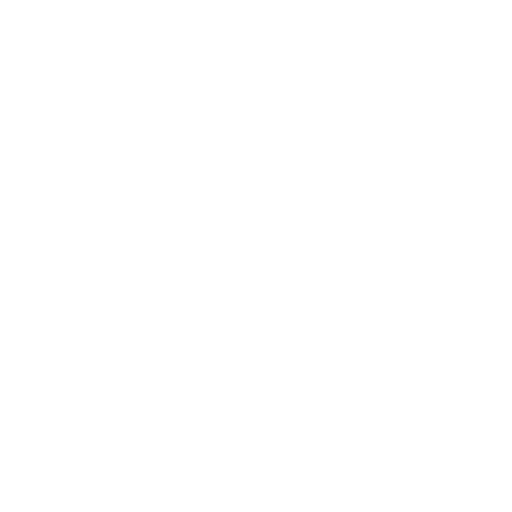

In [50]:
mask = Image.open('mask.png')
mask

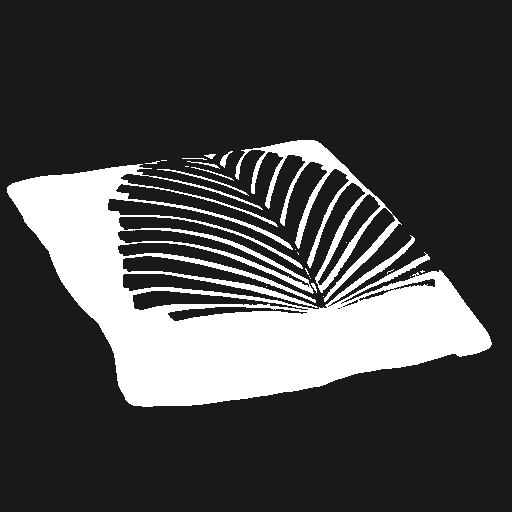

In [27]:
# we can make a rough mask by thresholding the grayscaled image

import numpy as np

img2_grayscale = img2.convert('L')
img2_a = np.array(img2_grayscale)

mask = np.array(img2_grayscale)
mask[img2_a<150] = 1  # this is the area that will get painted, will show up black below
mask[img2_a>=150] = 1 # this is the protected area, will show up white below

strength = .9  # this controls the "strength" of the prompt relative to the init image

d = int(255 * (1-strength))
mask *= 255-d # convert from range [0,1] to [0,255]
mask += d

mask = Image.fromarray(mask)
mask

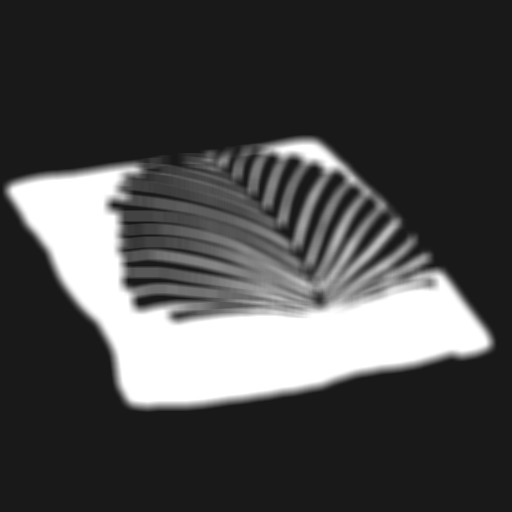

In [28]:
# fuzzing the mask edges generally improves synthesis results

from torchvision.transforms import GaussianBlur

blur = GaussianBlur(11,20)
mask = blur(mask)
mask

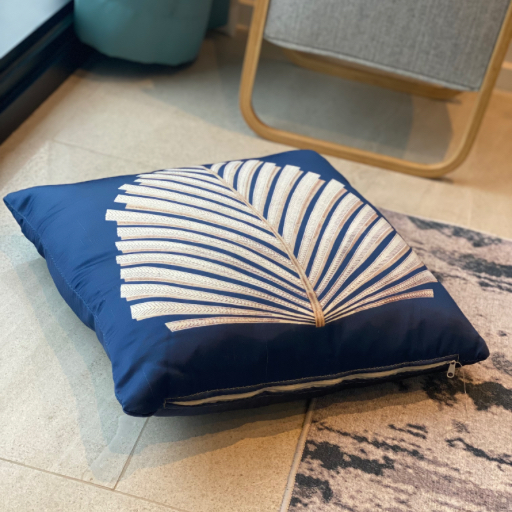

In [132]:
img2 = Image.open('pillow.png')
img2

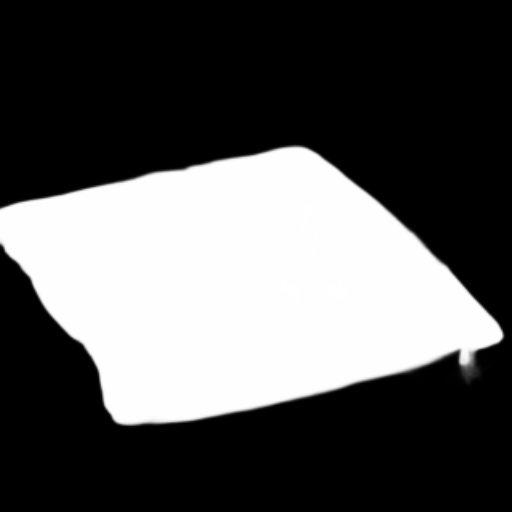

In [171]:
mask = Image.open('/content/U-2-Net/test_data/u2net_results/cushion.png')
mask

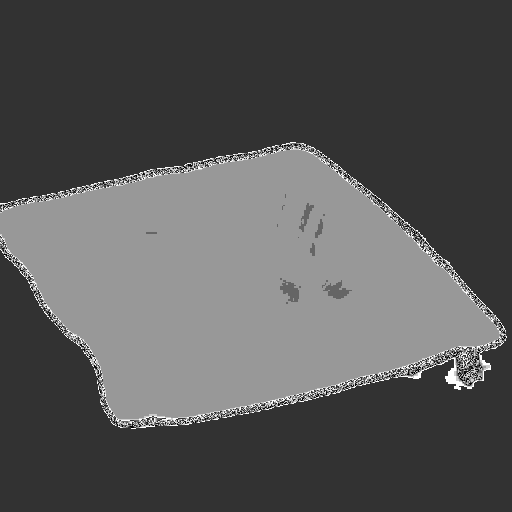

In [157]:


mask = np.array(mask)
# mask[img2_a<150] = 1  # this is the area that will get painted, will show up black below
# mask[img2_a>=150] = 0 # this is the protected area, will show up white below

strength = .8  # this controls the "strength" of the prompt relative to the init image

d = int(255 * (1-strength))
mask *= 255-d # convert from range [0,1] to [0,255]
mask += d

mask = Image.fromarray(mask)
mask

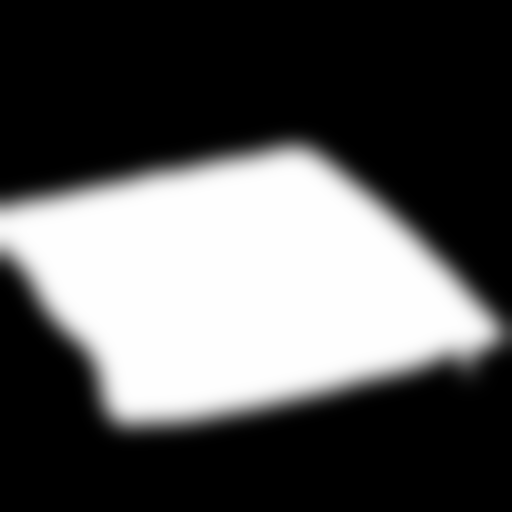

In [167]:
from torchvision.transforms import GaussianBlur

blur = GaussianBlur(33,10) # 11,20
mask = blur(mask)
mask

INFO:stability_sdk.client:Sending request.
INFO:stability_sdk.client:Got keepalive 3b1217ff-8e5a-4502-8e97-1183ff9c6341 in 0.88s
INFO:stability_sdk.client:Got keepalive 3b1217ff-8e5a-4502-8e97-1183ff9c6341 in 2.72s
INFO:stability_sdk.client:Got 3b1217ff-8e5a-4502-8e97-1183ff9c6341 with ['ARTIFACT_IMAGE', 'ARTIFACT_CLASSIFICATIONS'] in 0.43s


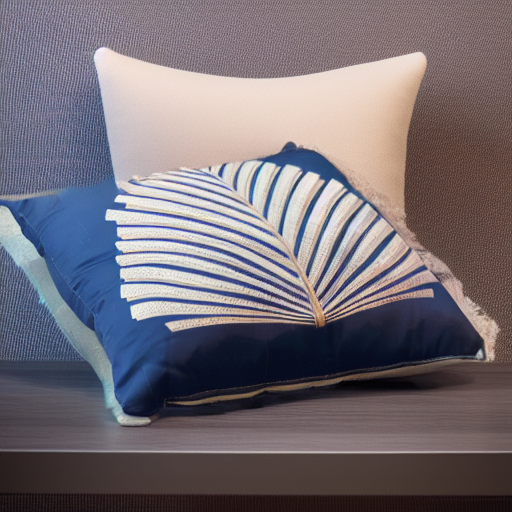

In [173]:
# now, let's send our drawing into space
answers = stability_api.generate(
    prompt="A stunning, professional product shot of a designer pillow highlighted in a showroom, product photography",
    init_image=img2,
    mask_image=mask,
    seed=12345, # if we're passing in an image generated by SD, you may get better results by providing a different seed value than was used to generate the image
    start_schedule=1,
)

for resp in answers:
    for artifact in resp.artifacts:
        if artifact.finish_reason == generation.FILTER:
            warnings.warn(
                "Your request activated the API's safety filters and could not be processed."
                "Please modify the prompt and try again.")
        if artifact.type == generation.ARTIFACT_IMAGE:
            img3 = Image.open(io.BytesIO(artifact.binary))
            display(img3)

INFO:stability_sdk.client:Sending request.
INFO:stability_sdk.client:Got keepalive 89c76a93-7c7f-4333-b382-c5bb9a5d33dc in 0.21s
INFO:stability_sdk.client:Got keepalive 89c76a93-7c7f-4333-b382-c5bb9a5d33dc in 29.80s
INFO:stability_sdk.client:Got 89c76a93-7c7f-4333-b382-c5bb9a5d33dc with ['ARTIFACT_IMAGE', 'ARTIFACT_CLASSIFICATIONS'] in 0.46s


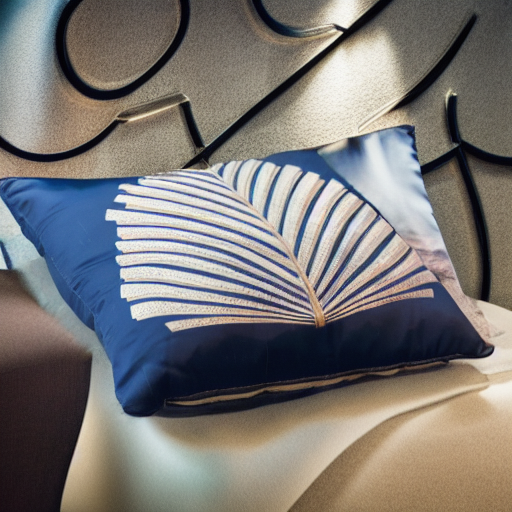

In [176]:
# now, let's send our drawing into space
answers = stability_api.generate(
    prompt="A stunning, professional product shot of a designer pillow highlighted in a showroom, product photography",
    init_image=img2,
    mask_image=mask,
    seed=34567, 
    steps=35, 
    guidance_preset = generation.GUIDANCE_PRESET_SLOWER,
    sampler = generation.SAMPLER_K_DPM_2_ANCESTRAL
)

for resp in answers:
    for artifact in resp.artifacts:
        if artifact.finish_reason == generation.FILTER:
            warnings.warn(
                "Your request activated the API's safety filters and could not be processed."
                "Please modify the prompt and try again.")
        if artifact.type == generation.ARTIFACT_IMAGE:
            img3 = Image.open(io.BytesIO(artifact.binary))
            display(img3)

INFO:stability_sdk.client:Sending request.
INFO:stability_sdk.client:Got keepalive 1653d87f-0d5a-447a-9667-6d51d4cf59d9 in 0.65s
INFO:stability_sdk.client:Got keepalive 1653d87f-0d5a-447a-9667-6d51d4cf59d9 in 28.51s
INFO:stability_sdk.client:Got 1653d87f-0d5a-447a-9667-6d51d4cf59d9 with ['ARTIFACT_IMAGE', 'ARTIFACT_CLASSIFICATIONS'] in 0.36s


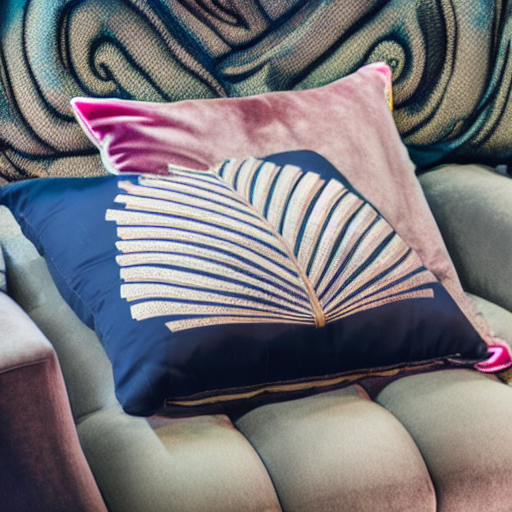

In [177]:
# now, let's send our drawing into space
answers = stability_api.generate(
    prompt="A stunning, professional product shot of a designer pillow on top of a pink sofa, product photography",
    init_image=img2,
    mask_image=mask,
    seed=34567, 
    steps=35, 
    guidance_preset = generation.GUIDANCE_PRESET_SLOWER,
    sampler = generation.SAMPLER_K_DPM_2_ANCESTRAL
)

for resp in answers:
    for artifact in resp.artifacts:
        if artifact.finish_reason == generation.FILTER:
            warnings.warn(
                "Your request activated the API's safety filters and could not be processed."
                "Please modify the prompt and try again.")
        if artifact.type == generation.ARTIFACT_IMAGE:
            img3 = Image.open(io.BytesIO(artifact.binary))
            display(img3)

INFO:stability_sdk.client:Sending request.
INFO:stability_sdk.client:Got keepalive 3272ac6d-9ab9-43de-96be-c2ee8dccb184 in 0.28s
INFO:stability_sdk.client:Got keepalive 3272ac6d-9ab9-43de-96be-c2ee8dccb184 in 30.03s
INFO:stability_sdk.client:Got keepalive 3272ac6d-9ab9-43de-96be-c2ee8dccb184 in 30.00s
INFO:stability_sdk.client:Got keepalive 3272ac6d-9ab9-43de-96be-c2ee8dccb184 in 30.00s
INFO:stability_sdk.client:Got keepalive 3272ac6d-9ab9-43de-96be-c2ee8dccb184 in 0.50s
INFO:stability_sdk.client:Got 3272ac6d-9ab9-43de-96be-c2ee8dccb184 with ['ARTIFACT_IMAGE', 'ARTIFACT_CLASSIFICATIONS'] in 0.08s


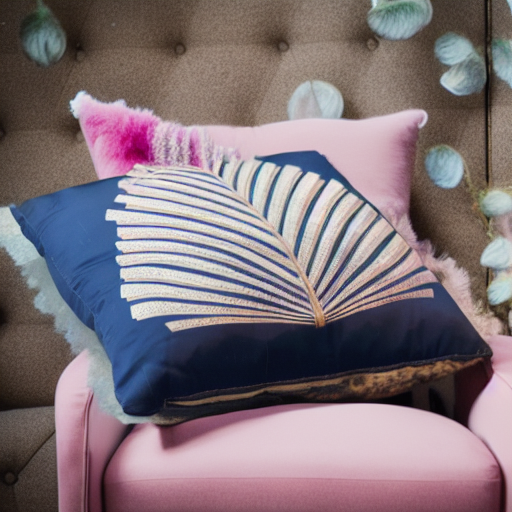

In [178]:
# now, let's send our drawing into space
answers = stability_api.generate(
    prompt="A stunning, professional product shot of a designer pillow on top of a pink sofa, product photography",
    init_image=img2,
    mask_image=mask,
    seed=34567, 
    steps=100,
    guidance_preset = generation.GUIDANCE_PRESET_SLOWER,
    sampler = generation.SAMPLER_K_DPM_2_ANCESTRAL
)

for resp in answers:
    for artifact in resp.artifacts:
        if artifact.finish_reason == generation.FILTER:
            warnings.warn(
                "Your request activated the API's safety filters and could not be processed."
                "Please modify the prompt and try again.")
        if artifact.type == generation.ARTIFACT_IMAGE:
            img3 = Image.open(io.BytesIO(artifact.binary))
            display(img3)

INFO:stability_sdk.client:Sending request.
INFO:stability_sdk.client:Got keepalive 43d88cd9-ef8a-4812-a941-3bff0b72bc18 in 0.61s
INFO:stability_sdk.client:Got keepalive 43d88cd9-ef8a-4812-a941-3bff0b72bc18 in 30.00s
INFO:stability_sdk.client:Got keepalive 43d88cd9-ef8a-4812-a941-3bff0b72bc18 in 6.31s
INFO:stability_sdk.client:Got 43d88cd9-ef8a-4812-a941-3bff0b72bc18 with ['ARTIFACT_IMAGE', 'ARTIFACT_CLASSIFICATIONS'] in 0.38s


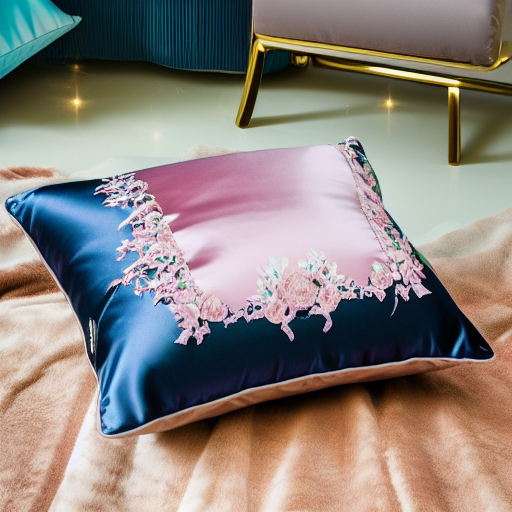

In [202]:
# now, let's send our drawing into space
answers = stability_api.generate(
    prompt="A stunning professional product shot of a beautiful cushion with on pink satin sheets",
    init_image=img2,
    # mask_image=mask,
    seed=34567, 
    steps=50,
    cfg_scale=18.0,
    start_schedule=0.8,
    samples=1,
    guidance_preset = generation.GUIDANCE_PRESET_SLOWER,
    sampler = generation.SAMPLER_K_DPM_2_ANCESTRAL,
)

for resp in answers:
    for artifact in resp.artifacts:
        if artifact.finish_reason == generation.FILTER:
            warnings.warn(
                "Your request activated the API's safety filters and could not be processed."
                "Please modify the prompt and try again.")
        if artifact.type == generation.ARTIFACT_IMAGE:
            img3 = Image.open(io.BytesIO(artifact.binary))
            display(img3)

INFO:stability_sdk.client:Sending request.
INFO:stability_sdk.client:Got keepalive 8037b199-7079-4629-afdc-97c7617d9a00 in 0.46s
INFO:stability_sdk.client:Got keepalive 8037b199-7079-4629-afdc-97c7617d9a00 in 30.02s
INFO:stability_sdk.client:Got keepalive 381cf069-1602-499f-b464-4949aac91033 in 4.90s
INFO:stability_sdk.client:Got keepalive 381cf069-1602-499f-b464-4949aac91033 in 30.02s
INFO:stability_sdk.client:Got keepalive 381cf069-1602-499f-b464-4949aac91033 in 10.66s
INFO:stability_sdk.client:Got 381cf069-1602-499f-b464-4949aac91033 with ['ARTIFACT_IMAGE', 'ARTIFACT_CLASSIFICATIONS'] in 0.39s


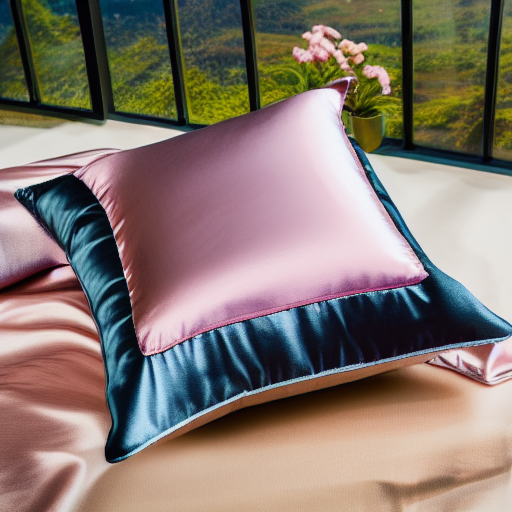

In [204]:
# now, let's send our drawing into space
answers = stability_api.generate(
    prompt="A stunning professional product shot of a beautiful cushion with on pink satin sheets",
    init_image=img2,
    # mask_image=mask,
    seed=34567, 
    steps=50,
    cfg_scale=17.0,
    start_schedule=0.9,
    samples=1,
    guidance_preset = generation.GUIDANCE_PRESET_SLOWER,
    sampler = generation.SAMPLER_K_DPM_2_ANCESTRAL,
)

for resp in answers:
    for artifact in resp.artifacts:
        if artifact.finish_reason == generation.FILTER:
            warnings.warn(
                "Your request activated the API's safety filters and could not be processed."
                "Please modify the prompt and try again.")
        if artifact.type == generation.ARTIFACT_IMAGE:
            img3 = Image.open(io.BytesIO(artifact.binary))
            display(img3)

In [ ]:
# we can improve our image result by introducing clip guidance into the request. this takes longer (and costs more compute) but often yields better results.
# clip guidance is built with several presets optimized for speed or quality, but clip can be controlled more precisely with a variety of other params

answers = stability_api.generate(
    prompt="houston, we are a 'go' for launch!",
    seed=34567,  
    steps=35, # minimum of 35 steps recommended when using CLIP
    guidance_preset = generation.GUIDANCE_PRESET_FAST_BLUE
)

for resp in answers:
    for artifact in resp.artifacts:
        if artifact.finish_reason == generation.FILTER:
            warnings.warn(
                "Your request activated the API's safety filters and could not be processed."
                "Please modify the prompt and try again.")
        if artifact.type == generation.ARTIFACT_IMAGE:
            img4 = Image.open(io.BytesIO(artifact.binary))
            print('GUIDANCE: FAST-BLUE:')
            display(img4)

answers = stability_api.generate(
    prompt="houston, we are a 'go' for launch!",
    seed=34567, 
    steps=35, 
    guidance_preset = generation.GUIDANCE_PRESET_SLOWER
)

for resp in answers:
    for artifact in resp.artifacts:
        if artifact.finish_reason == generation.FILTER:
            warnings.warn(
                "Your request activated the API's safety filters and could not be processed."
                "Please modify the prompt and try again.")
        if artifact.type == generation.ARTIFACT_IMAGE:
            img5 = Image.open(io.BytesIO(artifact.binary))
            print('GUIDANCE: SLOWER:')
            display(img5)